In [1]:
# Simplified MNIST loading using torchvision
import torch
import torchvision
from torchvision import transforms
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader

# Define transforms for MNIST
transform = transforms.Compose([
    transforms.ToTensor(),  # Convert PIL Image to tensor and scale to [0,1]
    transforms.Normalize((0.5,), (0.5,))  # Normalize to [-1, 1] range
])

# Load MNIST dataset
train_dataset = torchvision.datasets.MNIST(
    root='../datasets', 
    train=True, 
    download=True, 
    transform=transform
)

test_dataset = torchvision.datasets.MNIST(
    root='../datasets', 
    train=False, 
    download=True, 
    transform=transform
)

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

print(f"Training samples: {len(train_dataset)}")
print(f"Test samples: {len(test_dataset)}")
print(f"Number of classes: {len(train_dataset.classes)}")

# Get a sample batch to understand the data shape
sample_batch, sample_labels = next(iter(train_loader))
print(f"Sample batch shape: {sample_batch.shape}")  # [batch_size, 1, 28, 28]
print(f"Sample labels shape: {sample_labels.shape}")  # [batch_size]

100%|██████████| 9.91M/9.91M [00:01<00:00, 8.11MB/s]

100%|██████████| 28.9k/28.9k [00:00<00:00, 311kB/s]

100%|██████████| 1.65M/1.65M [00:00<00:00, 2.39MB/s]

100%|██████████| 4.54k/4.54k [00:00<00:00, 4.52MB/s]

Training samples: 60000
Test samples: 10000
Number of classes: 10
Sample batch shape: torch.Size([64, 1, 28, 28])
Sample labels shape: torch.Size([64])


Training samples:


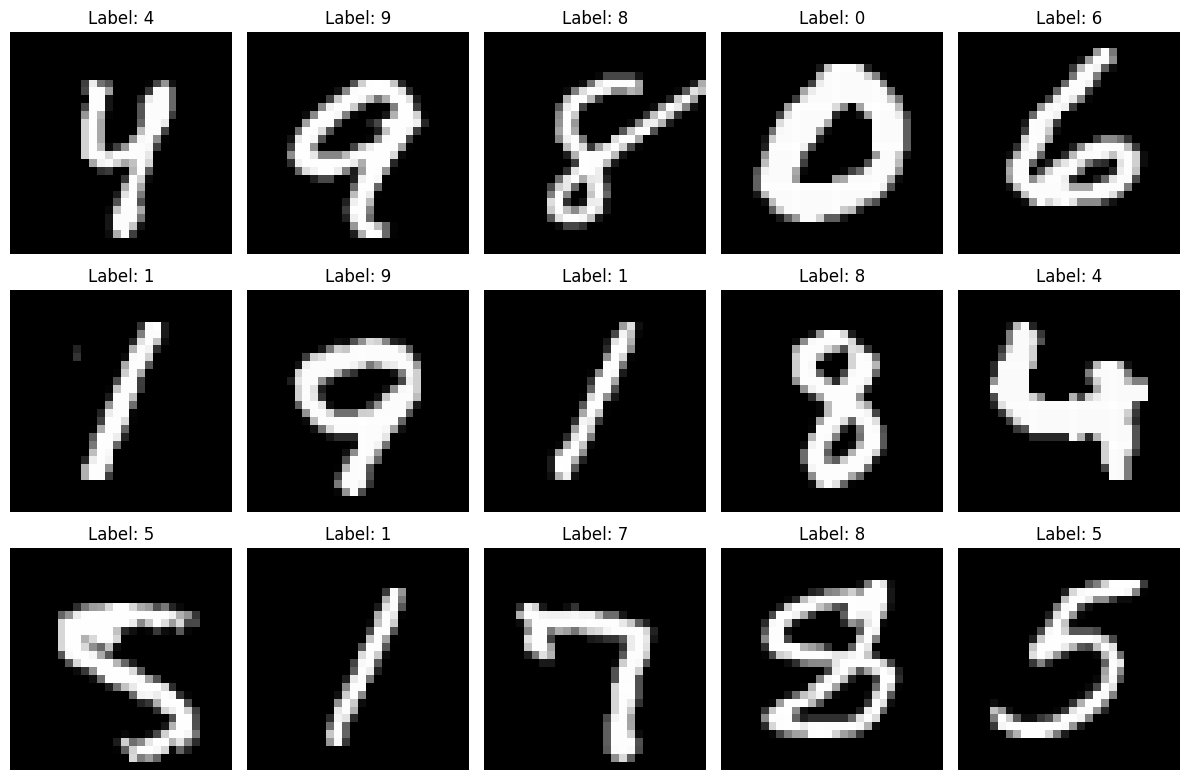

Test samples:


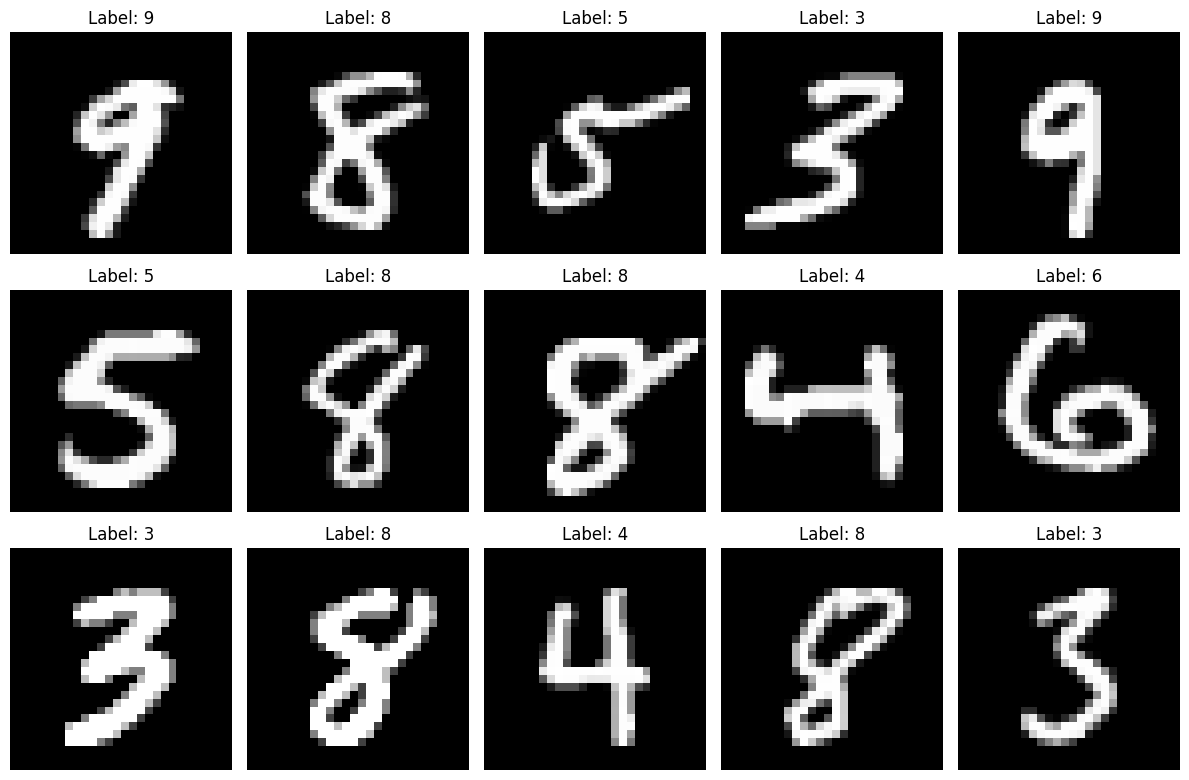

In [2]:
# Visualize some MNIST samples
%matplotlib inline
import random

def show_mnist_samples(dataset, num_samples=15):
    """Show random samples from MNIST dataset"""
    fig, axes = plt.subplots(3, 5, figsize=(12, 8))
    axes = axes.ravel()
    
    for i in range(num_samples):
        # Get random sample
        idx = random.randint(0, len(dataset) - 1)
        image, label = dataset[idx]
        
        # Convert tensor to numpy for visualization
        image_np = image.squeeze().numpy()  # Remove channel dimension
        
        axes[i].imshow(image_np, cmap='gray')
        axes[i].set_title(f'Label: {label}')
        axes[i].axis('off')
    
    plt.tight_layout()
    plt.show()

# Show some training samples
print("Training samples:")
show_mnist_samples(train_dataset, 15)

# Show some test samples  
print("Test samples:")
show_mnist_samples(test_dataset, 15)

In [ ]:
import torch
from torch import nn
import torch.nn.functional as F
from einops.layers.torch import Rearrange
from torch import Tensor

# Data preprocessing for MNIST to work with ViT
def preprocess_mnist_for_vit(images, target_size=224, make_rgb=True):
    """
    Preprocess MNIST images for Vision Transformer
    Args:
        images: Tensor of shape [batch_size, 1, 28, 28]
        target_size: Target image size (default 224 for standard ViT)
        make_rgb: Whether to convert grayscale to RGB
    Returns:
        Preprocessed images of shape [batch_size, channels, target_size, target_size]
    """
    # Resize images to target size
    if target_size != 28:
        images = F.interpolate(images, size=(target_size, target_size), mode='bilinear', align_corners=False)
    
    # Convert to RGB if needed
    if make_rgb and images.shape[1] == 1:
        images = images.repeat(1, 3, 1, 1)  # [batch, 1, H, W] -> [batch, 3, H, W]
    
    return images

# Patch Embedding for Vision Transformer
class PatchEmbedding(nn.Module):
    def __init__(self, in_channels=3, patch_size=16, embedding_size=768, image_size=224):
        super().__init__()
        self.patch_size = patch_size
        self.num_patches = (image_size // patch_size) ** 2
        
        self.projection = nn.Sequential(
            # Rearrange patches: (batch, channels, height, width) -> (batch, num_patches, patch_features)
            Rearrange('b c (h p1) (w p2) -> b (h w) (p1 p2 c)', p1=patch_size, p2=patch_size),
            # Linear projection to embedding dimension
            nn.Linear(patch_size * patch_size * in_channels, embedding_size)
        )

    def forward(self, x: Tensor) -> Tensor:
        return self.projection(x)



Testing MNIST preprocessing and patch embedding:
Original MNIST batch shape: torch.Size([64, 1, 28, 28])
Small patches (28x28 images, 7x7 patches): torch.Size([64, 16, 128])
Resized MNIST batch shape: torch.Size([64, 3, 224, 224])
Standard patches (224x224 images, 16x16 patches): torch.Size([64, 196, 768])
✅ Data preprocessing successful! Ready for Vision Transformer.


Creating ViT-ready data loaders...
ViT-ready batch shape: torch.Size([32, 3, 224, 224])
Labels shape: torch.Size([32])
Final patches shape: torch.Size([32, 196, 768])
Comparing the same image (index 0, label: 5)


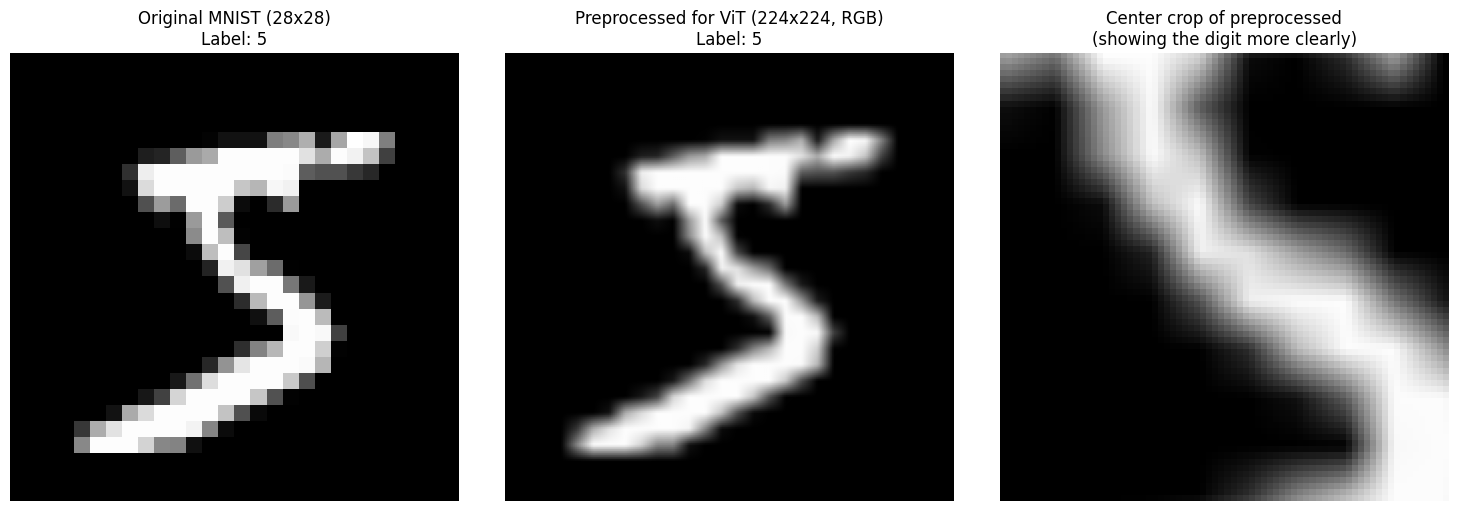

✅ Confirmed: Both images show the same digit (5)

🎉 Complete MNIST preprocessing pipeline ready for Vision Transformer!
✅ Data loaders created
✅ Patch embedding tested
✅ Shape: torch.Size([32, 3, 224, 224]) -> torch.Size([32, 196, 768])
✅ Ready to build the full Vision Transformer!


In [5]:
# Utility functions for working with the preprocessed data

def create_mnist_dataloaders_for_vit(batch_size=32, target_size=224, make_rgb=True):
    """
    Create DataLoaders with preprocessing for Vision Transformer
    """
    def vit_transform(image, label):
        # Convert PIL to tensor
        image = transforms.ToTensor()(image)
        # Normalize
        image = transforms.Normalize((0.5,), (0.5,))(image)
        # Preprocess for ViT
        image = preprocess_mnist_for_vit(image.unsqueeze(0), target_size, make_rgb).squeeze(0)
        return image, label
    
    # Create datasets with ViT preprocessing
    train_dataset_vit = torchvision.datasets.MNIST(
        root='../datasets', train=True, download=False,
        transform=transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize((0.5,), (0.5,)),
            transforms.Lambda(lambda x: preprocess_mnist_for_vit(x.unsqueeze(0), target_size, make_rgb).squeeze(0))
        ])
    )
    
    test_dataset_vit = torchvision.datasets.MNIST(
        root='../datasets', train=False, download=False,
        transform=transforms.Compose([
            transforms.ToTensor(), 
            transforms.Normalize((0.5,), (0.5,)),
            transforms.Lambda(lambda x: preprocess_mnist_for_vit(x.unsqueeze(0), target_size, make_rgb).squeeze(0))
        ])
    )
    
    train_loader_vit = DataLoader(train_dataset_vit, batch_size=batch_size, shuffle=True)
    test_loader_vit = DataLoader(test_dataset_vit, batch_size=batch_size, shuffle=False)
    
    return train_loader_vit, test_loader_vit

# Create ViT-ready data loaders
print("Creating ViT-ready data loaders...")
train_loader_vit, test_loader_vit = create_mnist_dataloaders_for_vit(batch_size=32, target_size=224, make_rgb=True)

# Test the complete pipeline
vit_batch, vit_labels = next(iter(train_loader_vit))
print(f"ViT-ready batch shape: {vit_batch.shape}")  # [32, 3, 224, 224]
print(f"Labels shape: {vit_labels.shape}")  # [32]

# Test patch embedding on the preprocessed data
patch_embed = PatchEmbedding(in_channels=3, patch_size=16, embedding_size=768, image_size=224)
patches = patch_embed(vit_batch)
print(f"Final patches shape: {patches.shape}")  # [32, 196, 768]

# Visualize the same image before and after preprocessing
plt.figure(figsize=(15, 5))

# Get the same image from both datasets for comparison
sample_idx = 0  # Use the same index for both
original_image, original_label = train_dataset[sample_idx]  # Original dataset
vit_image, vit_label = train_loader_vit.dataset[sample_idx]  # ViT dataset

print(f"Comparing the same image (index {sample_idx}, label: {original_label})")

# Show original MNIST (28x28, grayscale)
plt.subplot(1, 3, 1)
plt.imshow(original_image.squeeze(), cmap='gray')
plt.title(f'Original MNIST (28x28)\nLabel: {original_label}')
plt.axis('off')

# Show preprocessed for ViT (224x224, RGB)
plt.subplot(1, 3, 2)
preprocessed = vit_image.permute(1, 2, 0)  # CHW -> HWC for display
# Convert back from [-1,1] to [0,1] for visualization
preprocessed = (preprocessed + 1) / 2
plt.imshow(preprocessed)
plt.title(f'Preprocessed for ViT (224x224, RGB)\nLabel: {vit_label}')
plt.axis('off')

# Show a zoomed-in view of the center of the preprocessed image
plt.subplot(1, 3, 3)
center_crop = preprocessed[75:149, 75:149]  # Crop center region
plt.imshow(center_crop)
plt.title('Center crop of preprocessed\n(showing the digit more clearly)')
plt.axis('off')

plt.tight_layout()
plt.show()

# Verify they're the same digit
assert original_label == vit_label, f"Labels don't match! Original: {original_label}, ViT: {vit_label}"
print(f"✅ Confirmed: Both images show the same digit ({original_label})")

print("\n🎉 Complete MNIST preprocessing pipeline ready for Vision Transformer!")
print(f"✅ Data loaders created")
print(f"✅ Patch embedding tested") 
print(f"✅ Shape: {vit_batch.shape} -> {patches.shape}")
print(f"✅ Ready to build the full Vision Transformer!")

In [6]:
class ViT(nn.Module):
    def __init__(
            self,
            ch=3,
            img_size = 224,
            patch_size=16,
            embedding_size=768,
            n_layers=12,
            num_heads=12,
            num_classes=10,
            dropout=0.1):
        super(ViT, self).__init__()

        self.channels = ch
        self.height = img_size
        self.width = img_size
        self.patch_size = patch_size
        self.n_layers = n_layers

        self.patch_embedding = PatchEmbedding(in_channels=ch,
                                              patch_size= patch_size,
                                              embedding_size=embedding_size)
        
        num_patches = (img_size // patch_size) ** 2
        self.pos_embedding = nn.Parameter(torch.randn(1, num_patches + 1, embedding_size) * 0.02)
        self.cls_token = nn.Parameter(torch.rand(1, 1, embedding_size) * 0.02)

        # Transformer blocks
        encoder_layer = nn.TransformerEncoderLayer(
                    d_model=embedding_size,
                    nhead=num_heads,
                    dim_feedforward=embedding_size * 4,
                    dropout=dropout,
                    activation='gelu',  # GELU is standard for ViT
                    batch_first=True,   # Important: batch dimension first
                    norm_first=True     # Pre-layer norm (standard for ViT)
        )
                
        self.transformer_encoder = nn.TransformerEncoder(
            encoder_layer=encoder_layer,
            num_layers=n_layers
        )

        self.layer_norm = nn.LayerNorm(embedding_size)
        self.classifier = nn.Linear(embedding_size, num_classes)
        self.dropout = nn.Dropout(dropout)

    
    def forward(self, x):
            batch_size = x.shape[0]
            
            # Patch embedding: (batch, 3, 224, 224) -> (batch, 196, 768)
            x = self.patch_embedding(x)
            
            # Add CLS token: (batch, 196, 768) -> (batch, 197, 768)
            cls_tokens = self.cls_token.expand(batch_size, -1, -1)
            x = torch.cat([cls_tokens, x], dim=1)
            
            # Add positional embeddings
            x = x + self.pos_embedding
            x = self.dropout(x)
            
            # Transformer encoder
            x = self.transformer_encoder(x)
            
            # Classification head - use CLS token (first token)
            cls_output = self.layer_norm(x[:, 0])  # Take CLS token
            output = self.classifier(cls_output)
            
            return output

In [ ]:
# Test the preprocessing and patch embedding
print("Testing MNIST preprocessing and patch embedding:")

# Get a batch of MNIST data
sample_batch, sample_labels = next(iter(train_loader))
print(f"Original MNIST batch shape: {sample_batch.shape}")  # [64, 1, 28, 28]

# Option 1: Use smaller patches for 28x28 images (keeping original size)
patch_embed_small = PatchEmbedding(in_channels=1, patch_size=7, embedding_size=128, image_size=28)
patches_small = patch_embed_small(sample_batch)
print(f"Small patches (28x28 images, 7x7 patches): {patches_small.shape}")  # [64, 16, 128]

# Option 2: Resize to 224x224 and use standard ViT settings
sample_batch_resized = preprocess_mnist_for_vit(sample_batch, target_size=224, make_rgb=True)
print(f"Resized MNIST batch shape: {sample_batch_resized.shape}")  # [64, 3, 224, 224]

patch_embed_standard = PatchEmbedding(in_channels=3, patch_size=16, embedding_size=768, image_size=224)
patches_standard = patch_embed_standard(sample_batch_resized)
print(f"Standard patches (224x224 images, 16x16 patches): {patches_standard.shape}")  # [64, 196, 768]

print("✅ Data preprocessing successful! Ready for Vision Transformer.")



# Test the complete ViT
print("Testing complete Vision Transformer:")

# Create model
model = ViT(ch=3, img_size=224, patch_size=16, embedding_size=768, 
           n_layers=6, num_heads=8, num_classes=10, dropout=0.1)

# Test forward pass
test_input = torch.randn(2, 3, 224, 224)  # Batch of 2 images
with torch.no_grad():
    output = model(test_input)

print(f"Input shape: {test_input.shape}")   # [2, 3, 224, 224]
print(f"Output shape: {output.shape}")      # [2, 10]
print(f"Output (logits): {output}")

# Count parameters
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Total parameters: {total_params:,}")
print(f"Trainable parameters: {trainable_params:,}")

print("✅ Complete Vision Transformer working!")

Testing complete Vision Transformer:


c:\Users\rxh659-admin.UOB220566\anaconda3\envs\ml\Lib\site-packages\torch\nn\modules\transformer.py:382: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(


Input shape: torch.Size([2, 3, 224, 224])
Output shape: torch.Size([2, 10])
Output (logits): tensor([[ 0.3415, -0.6325,  0.2330,  0.7506,  0.6607,  0.4087, -0.0622, -0.9389,
          0.0701, -0.1183],
        [-0.3885, -0.4407, -0.0400,  0.6474, -0.2804,  0.2397,  0.0277, -2.1860,
         -0.7175, -0.3957]])
Total parameters: 43,279,114
Trainable parameters: 43,279,114
✅ Complete Vision Transformer working!


In [12]:
import torch.optim as optim
import os
import matplotlib.pyplot as plt
from datetime import datetime


# Create model, optimizer, loss function
model = ViT(ch=3, img_size=224, patch_size=16, embedding_size=768, 
           n_layers=6, num_heads=8, num_classes=10, dropout=0.1)

optimizer = optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-4)
criterion = nn.CrossEntropyLoss()

# Create directories for saving plots and predictions
os.makedirs('results', exist_ok=True)
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")

# Training function
def train_epoch(model, dataloader, optimizer, criterion, device='cpu'):
    model.train()  # Set to training mode
    total_loss = 0
    correct = 0
    total = 0
    
    for batch_idx, (data, target) in enumerate(dataloader):
        data, target = data.to(device), target.to(device)
        
        # Zero gradients from previous iteration
        optimizer.zero_grad()
        
        # Forward pass
        output = model(data)
        loss = criterion(output, target)
        
        # Backward pass - PyTorch computes all gradients automatically!
        loss.backward()
        
        # Update parameters
        optimizer.step()
        
        # Statistics
        total_loss += loss.item()
        pred = output.argmax(dim=1, keepdim=True)
        correct += pred.eq(target.view_as(pred)).sum().item()
        total += target.size(0)
        
        if batch_idx % 1 == 0:
            print(f'Batch {batch_idx}: Loss: {loss.item():.6f}')
    
    accuracy = 100. * correct / total
    avg_loss = total_loss / len(dataloader)
    return avg_loss, accuracy

In [13]:
# Test function
def test_epoch(model, dataloader, criterion, device='cpu'):
    model.eval()  # Set to evaluation mode
    total_loss = 0
    correct = 0
    total = 0
    
    with torch.no_grad():
        for data, target in dataloader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            loss = criterion(output, target)
            
            total_loss += loss.item()
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()
            total += target.size(0)
    
    accuracy = 100. * correct / total
    avg_loss = total_loss / len(dataloader)
    return avg_loss, accuracy

# Get fixed test images for prediction visualization
def get_fixed_test_samples(dataset, num_samples=10):
    """Get a fixed set of test samples for consistent evaluation"""
    fixed_indices = list(range(num_samples))  # Always use first 10 samples
    samples = []
    labels = []
    
    for idx in fixed_indices:
        image, label = dataset[idx]
        samples.append(image)
        labels.append(label)
    
    return torch.stack(samples), torch.tensor(labels)

# Prediction visualization function
def visualize_predictions(model, images, true_labels, device, epoch, save_path):
    """Visualize model predictions on fixed test images"""
    model.eval()
    
    with torch.no_grad():
        images = images.to(device)
        outputs = model(images)
        predictions = outputs.argmax(dim=1)
        probabilities = torch.softmax(outputs, dim=1)
    
    # Create visualization
    fig, axes = plt.subplots(2, 5, figsize=(15, 8))
    axes = axes.ravel()
    
    for i in range(len(images)):
        # Convert image for display
        img = images[i].cpu().permute(1, 2, 0)
        img = (img + 1) / 2  # Convert from [-1,1] to [0,1]
        
        axes[i].imshow(img)
        
        pred_label = predictions[i].item()
        true_label = true_labels[i].item()
        confidence = probabilities[i][pred_label].item()
        
        # Color: green if correct, red if wrong
        color = 'green' if pred_label == true_label else 'red'
        axes[i].set_title(f'True: {true_label}\nPred: {pred_label}\nConf: {confidence:.2f}', 
                         color=color, fontsize=10)
        axes[i].axis('off')
    
    plt.suptitle(f'Epoch {epoch+1} - Fixed Test Sample Predictions', fontsize=16)
    plt.tight_layout()
    plt.savefig(f'{save_path}/predictions_epoch_{epoch+1:02d}.png', dpi=150, bbox_inches='tight')
    plt.show()
    
    return predictions, probabilities

# Plot and save loss curves
def plot_loss_curves(train_losses, test_losses, train_accs, test_accs, save_path):
    """Plot and save training curves"""
    epochs = range(1, len(train_losses) + 1)
    
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 10))
    
    # Loss plots
    ax1.plot(epochs, train_losses, 'b-o', label='Training Loss', linewidth=2, markersize=6)
    ax1.set_title('Training Loss', fontsize=14)
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.grid(True, alpha=0.3)
    ax1.legend()
    
    ax2.plot(epochs, test_losses, 'r-o', label='Test Loss', linewidth=2, markersize=6)
    ax2.set_title('Test Loss', fontsize=14)
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Loss')
    ax2.grid(True, alpha=0.3)
    ax2.legend()
    
    # Accuracy plots
    ax3.plot(epochs, train_accs, 'b-o', label='Training Accuracy', linewidth=2, markersize=6)
    ax3.set_title('Training Accuracy', fontsize=14)
    ax3.set_xlabel('Epoch')
    ax3.set_ylabel('Accuracy (%)')
    ax3.grid(True, alpha=0.3)
    ax3.legend()
    
    ax4.plot(epochs, test_accs, 'r-o', label='Test Accuracy', linewidth=2, markersize=6)
    ax4.set_title('Test Accuracy', fontsize=14)
    ax4.set_xlabel('Epoch')
    ax4.set_ylabel('Accuracy (%)')
    ax4.grid(True, alpha=0.3)
    ax4.legend()
    
    plt.suptitle('Vision Transformer Training Progress', fontsize=16)
    plt.tight_layout()
    plt.savefig(f'{save_path}/training_curves_{timestamp}.png', dpi=300, bbox_inches='tight')
    plt.show()

In [14]:
# Train your ViT on MNIST
print("Training Vision Transformer on MNIST:")

# Use your preprocessed data loaders
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")
model = model.to(device)

# Get fixed test samples for consistent evaluation
fixed_test_images, fixed_test_labels = get_fixed_test_samples(test_loader_vit.dataset, num_samples=10)
print(f"Fixed test samples shape: {fixed_test_images.shape}")

# Initialize tracking lists
train_losses, test_losses = [], []
train_accs, test_accs = [], []

# Training loop
num_epochs = 5  # Increased for better visualization
for epoch in range(num_epochs):
    print(f"\n{'='*60}")
    print(f"Epoch {epoch+1}/{num_epochs}")
    print('='*60)
    
    # Training phase
    print("Training...")
    train_loss, train_acc = train_epoch(model, train_loader_vit, optimizer, criterion, device=device)
    
    # Test phase
    print("Testing...")
    test_loss, test_acc = test_epoch(model, test_loader_vit, criterion, device=device)
    
    # Store metrics
    train_losses.append(train_loss)
    test_losses.append(test_loss)
    train_accs.append(train_acc)
    test_accs.append(test_acc)
    
    # Print epoch results
    print(f"\nEpoch {epoch+1} Results:")
    print(f"Training   - Loss: {train_loss:.4f}, Accuracy: {train_acc:.2f}%")
    print(f"Test       - Loss: {test_loss:.4f}, Accuracy: {test_acc:.2f}%")
    
    # Visualize predictions on fixed test set
    print("Generating prediction visualizations...")
    predictions, probabilities = visualize_predictions(
        model, fixed_test_images, fixed_test_labels, device, epoch, 'results'
    )
    
    # Print prediction details
    print(f"Predictions: {predictions.cpu().numpy()}")
    print(f"True Labels: {fixed_test_labels.numpy()}")
    correct_predictions = (predictions.cpu() == fixed_test_labels).sum().item()
    print(f"Fixed Set Accuracy: {correct_predictions}/{len(fixed_test_labels)} ({100*correct_predictions/len(fixed_test_labels):.1f}%)")

# Final plots
print(f"\n{'='*60}")
print("Training Complete! Generating final plots...")
print('='*60)

plot_loss_curves(train_losses, test_losses, train_accs, test_accs, 'results')

# Save training metrics to file
import json
metrics = {
    'train_losses': train_losses,
    'test_losses': test_losses, 
    'train_accuracies': train_accs,
    'test_accuracies': test_accs,
    'timestamp': timestamp,
    'model_params': {
        'embedding_size': 768,
        'n_layers': 6,
        'num_heads': 8,
        'patch_size': 16,
        'img_size': 224
    }
}

with open(f'results/training_metrics_{timestamp}.json', 'w') as f:
    json.dump(metrics, f, indent=2)

print(f"✅ Training complete!")
print(f"✅ Plots saved to: results/training_curves_{timestamp}.png")
print(f"✅ Predictions saved to: results/predictions_epoch_XX.png")
print(f"✅ Metrics saved to: results/training_metrics_{timestamp}.json")
print(f"✅ Final Test Accuracy: {test_accs[-1]:.2f}%")

Training Vision Transformer on MNIST:
Using device: cpu
Fixed test samples shape: torch.Size([10, 3, 224, 224])

Epoch 1/5
Training...
Batch 0: Loss: 2.494681
Batch 1: Loss: 3.832938
Batch 2: Loss: 3.195872
Batch 3: Loss: 2.950860
Batch 4: Loss: 2.567522
Batch 5: Loss: 2.402417
Batch 6: Loss: 2.746093
Batch 7: Loss: 2.398985
Batch 8: Loss: 2.376457
Batch 9: Loss: 2.341502
Batch 10: Loss: 2.293906
Batch 11: Loss: 2.327174
Batch 12: Loss: 2.370462
Batch 13: Loss: 2.401247
Batch 14: Loss: 2.302670
Batch 15: Loss: 2.330514
Batch 16: Loss: 2.262414
Batch 17: Loss: 2.291117
Batch 18: Loss: 2.253428
Batch 19: Loss: 2.360635
Batch 20: Loss: 2.203255
Batch 21: Loss: 2.290648
Batch 22: Loss: 2.219717
Batch 23: Loss: 2.285197
Batch 24: Loss: 2.313881
Batch 25: Loss: 2.397147
Batch 26: Loss: 2.241426
Batch 27: Loss: 2.314291
Batch 28: Loss: 2.317942
Batch 29: Loss: 2.313682
Batch 30: Loss: 2.357372
Batch 31: Loss: 2.239449
Batch 32: Loss: 2.250824
Batch 33: Loss: 2.287727
Batch 34: Loss: 2.133082


KeyboardInterrupt: 